## Generating Noise

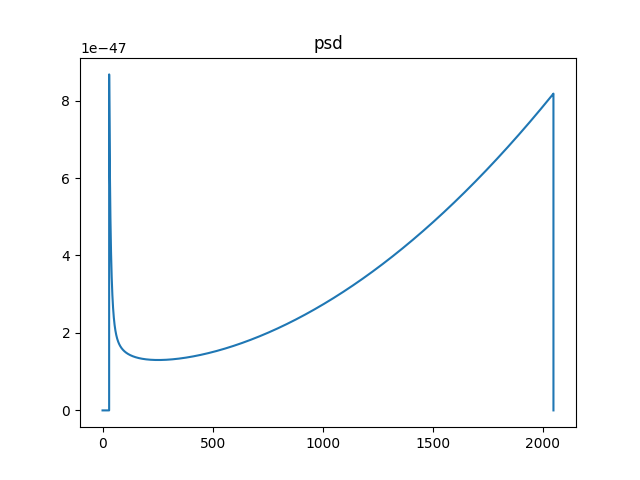

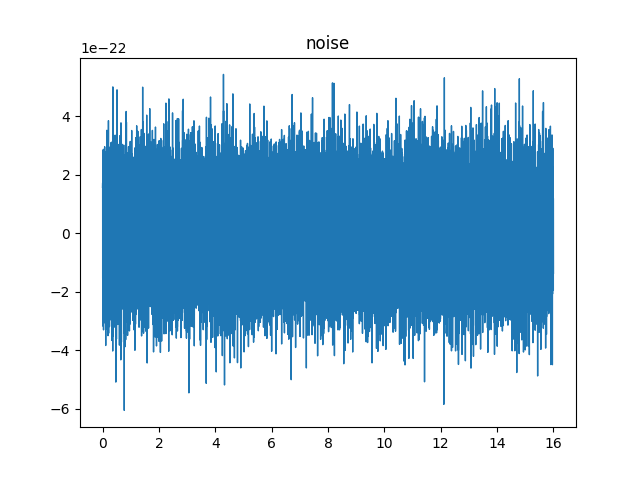

In [31]:
#getting psd

import numpy as np
import pycbc.noise
import pycbc.psd
import matplotlib.pyplot as plt
%matplotlib widget

flow=30.0
delta_f=1.0/16
flen=int(2048/delta_f)+1

psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)


plt.figure()
plt.plot(psd.sample_frequencies, psd)
plt.title("psd")
plt.show()


# getting noise from psd
delta_t=1/2048
t_samples=int(16/delta_t)


ts = pycbc.noise.gaussian.noise_from_psd(t_samples, delta_t, psd, seed=127)


plt.figure()
plt.plot(ts.sample_times, ts, linewidth=1)
plt.title("noise")
plt.show()


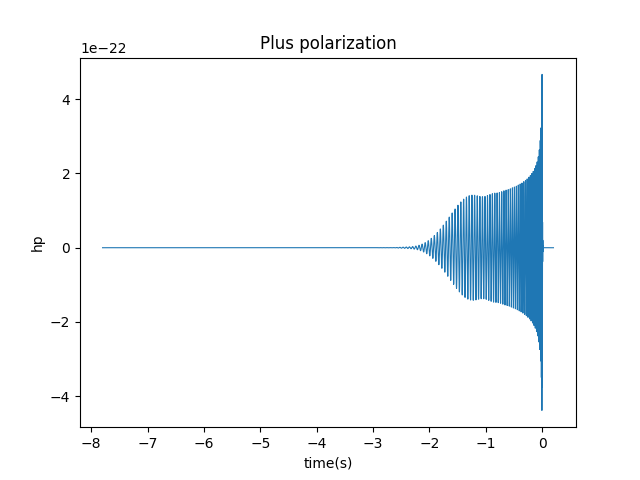

-0.414515456460921
-0.6051033320845963


In [28]:
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant='IMRPhenomD', mass1=10, mass2=50, distance=800, f_lower=20, delta_t=delta_t, coa_phase=0.0)

plt.close()
plt.figure()
plt.plot(hp.sample_times, hp, label='IMRPhenomD', linewidth=0.8)
plt.title('Plus polarization')
plt.ylabel("hp")
plt.xlabel('time(s)')
plt.show()


#get antenna patterns
ra=2.3
dec=1.7
t_gps=100000


det = Detector('H1') 

fp, fc = det.antenna_pattern(ra, dec, polarization=0.5, t_gps=t_gps)

print(fp)
print(fc)


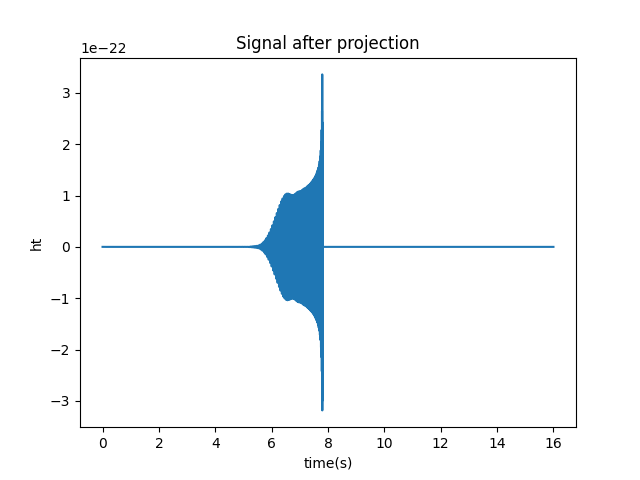

In [30]:
ht = fp*hp + fc*hc                      #projecting the signal onto detector frame

ht.resize(len(ts))                      #resizing length of signal to that of noise

ht.start_time = ts.start_time           #shifting the start time

plt.close()
plt.figure()
plt.plot(ht.sample_times, ht)
plt.title("Signal after projection")
plt.xlabel('time(s)')
plt.ylabel('ht')
plt.show()

## Signal

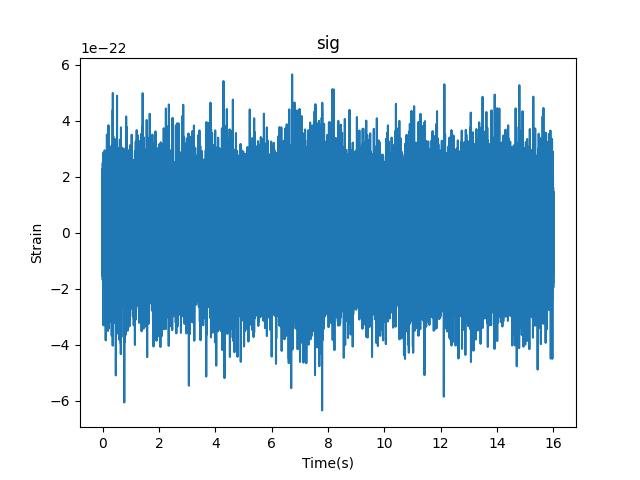

In [33]:
sig = ts + ht

plt.close()
plt.figure()
plt.plot(sig.sample_times, sig)
plt.title("sig")
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.show()

## Template

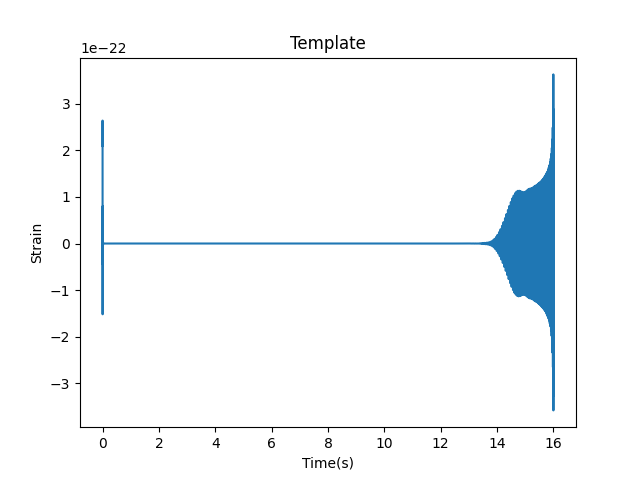

In [37]:
phase=np.pi/3

hpt, hct= get_td_waveform(approximant="IMRPhenomD", mass1=10, mass2=50,distance=1000, delta_t=sig.delta_t, f_lower=20, coa_phase=phase)


hpt.resize(len(sig))                                    # Resizing the vector to match the data

template = hpt.cyclic_time_shift(hpt.start_time)        

plt.close()
plt.figure()
plt.plot(template.sample_times, template)
plt.xlabel('Time(s)')
plt.ylabel('Strain')
plt.title("Template")
plt.show()

Text(0.5, 1.0, 'psd1')

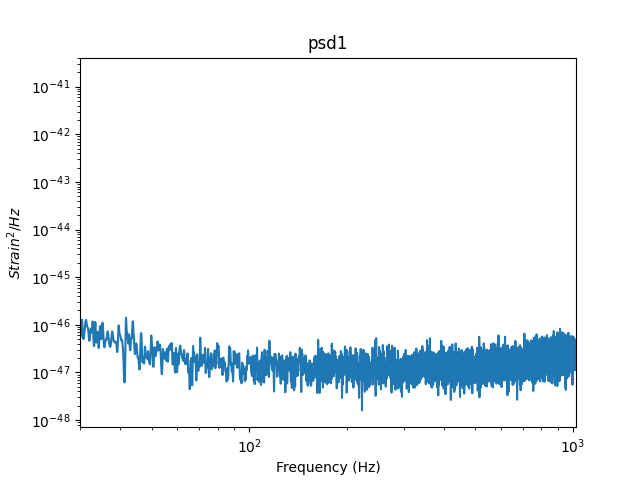

In [38]:
conditioned = sig

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd1 = conditioned.psd(4)

psd1 = interpolate(psd1, conditioned.delta_f)

psd1 = inverse_spectrum_truncation(psd1, int(4 * conditioned.sample_rate), low_frequency_cutoff=30)

plt.close()
plt.figure()
plt.loglog(psd1.sample_frequencies, psd1)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(30, 1024)
plt.title("psd1")

7.7998046875
20.105413785174644


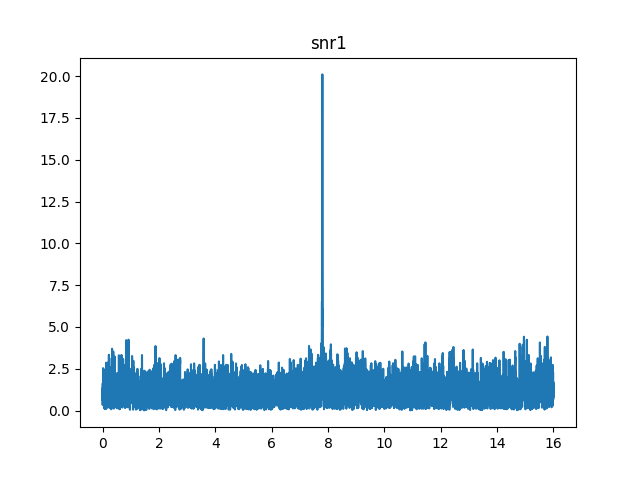

In [42]:
from pycbc.filter import matched_filter

snr = matched_filter(template, sig, psd=psd1, low_frequency_cutoff=30)

print (snr.sample_times.data[np.argmax(abs(snr))])
print(max(abs(snr)))


plt.close()
plt.figure()
plt.plot(snr.sample_times, abs(snr))
plt.title("snr1")
plt.show()




## Interactive graph for sliding template match filtering

interactive(children=(FloatSlider(value=0.0, description='n', max=20.0), Output()), _dom_classes=('widget-inte…

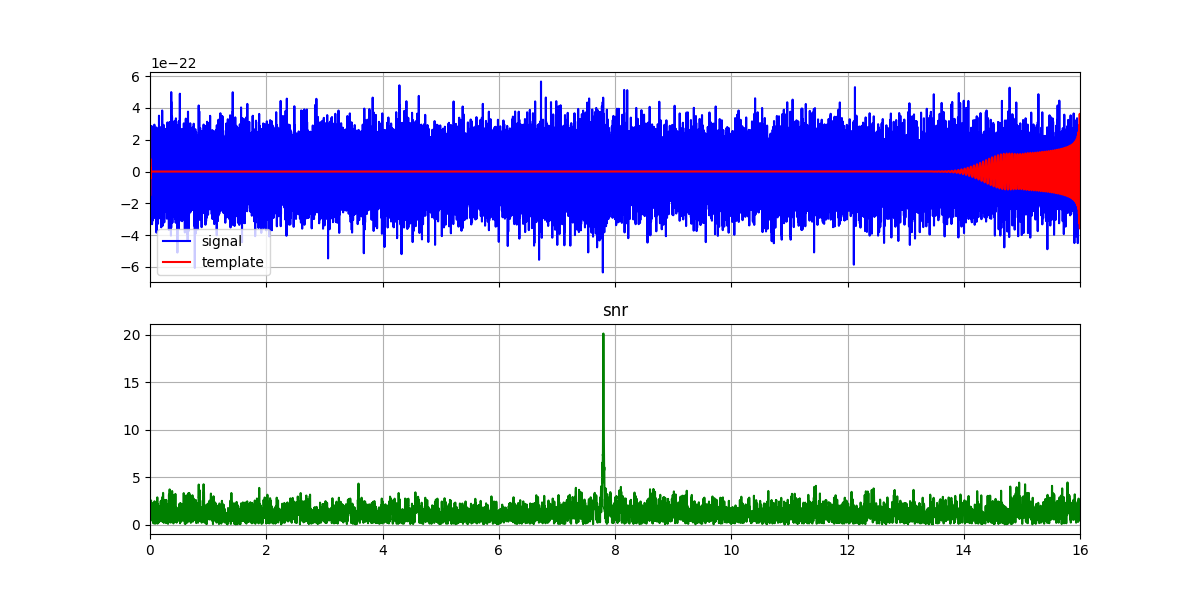

In [46]:
import ipywidgets as widgets

# set up plot
fig, axes = plt.subplots(2,1, figsize=(12, 6), sharex=True)
for ax in axes:
    ax.set_xlim([0, 16])
    ax.grid(True)
 
#hpt1, hct1= get_td_waveform(approximant="IMRPhenomD", mass1=10, mass2=50, distance=1000, delta_t=sig.delta_t, f_lower=20)

def template_mov(n):
    return hpt.start_time + n
 

@widgets.interact(n=(0, 20, 0.1))
def update(n = 0):
    hpt.resize(len(sig))
    template1 = hpt.cyclic_time_shift(template_mov(n))
    template1.start_time = sig.start_time

    snr = matched_filter(template1, sig, psd=psd1, low_frequency_cutoff=30)

    """Remove old lines from plot and plot new one"""
    for ax in axes:
        [l.remove() for l in ax.lines]

    axes[0].plot(sig.sample_times,sig, 'b', label='signal')
    axes[0].plot(template1.sample_times,template1, 'r', label='template')
    # axes[0].set_title("Signal")
    axes[0].legend()

    axes[1].plot(snr.sample_times, abs(snr), 'g')
    axes[1].set_title("snr")

In [16]:
chisq_bins = 0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak', 10, 50, 0.0, 0.0)**0.7
#0.72*pycbc.pnutils.get_freq('TaylorF2', 10, 50, 0.0, 0.0)**0.7
#0.72*pycbc.pnutils.get_freq('IMRPhenomD', 10, 50, 0.0, 0.0)**0.7
print (chisq_bins)

26.184645081505376


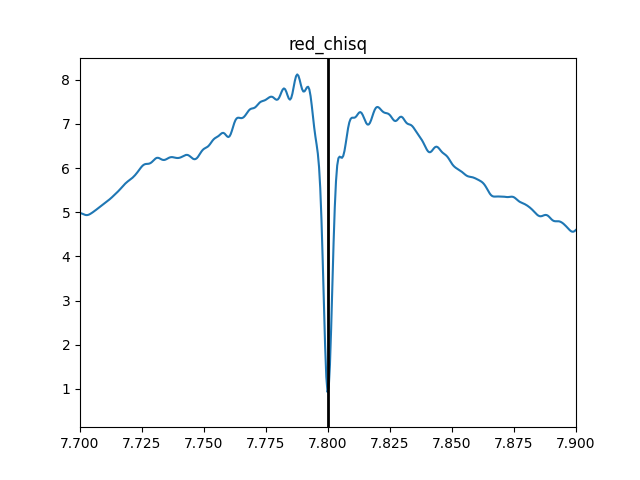

In [17]:
import pycbc.vetoes
import pycbc.waveform
import pycbc.psd
import pycbc.filter
import pycbc.types



# sig_f=sig.to_frequencyseries()
# template_f=template.to_frequencyseries()

num_bins= int(chisq_bins)

chisq= pycbc.vetoes.power_chisq(template1, sig, psd = psd1, num_bins=num_bins,
                                 low_frequency_cutoff=30.0)


red_chisq = chisq/(2*num_bins - 2)

#plt.plot(abs(chisq).sample_times, abs(chisq))

plt.close()
plt.figure()
plt.plot(red_chisq.sample_times, red_chisq.data)
plt.title("red_chisq")
snrmax = snr.sample_times.data[np.argmax(abs(snr))]
plt.axvline(x= snrmax,color='black',linewidth=2)
plt.xlim([7.7,7.9])
plt.show()

No such comm: 8dfe00b4d83d4bffabc54967ca8aad0d


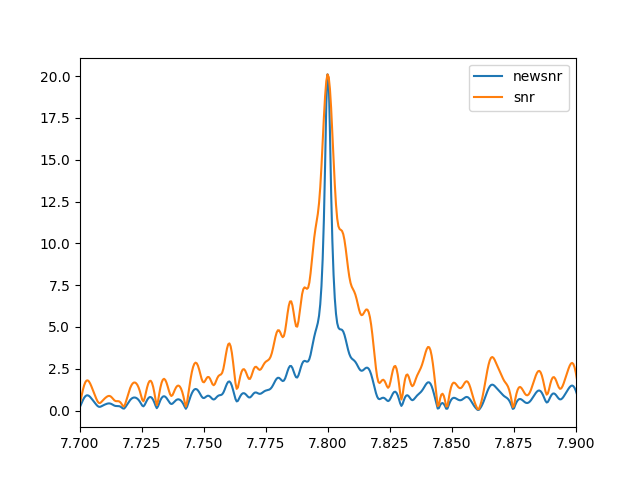

In [18]:
new_snr_arr=np.zeros(len(snr))

def new_snr(snr, red_chisq):

    if red_chisq > 1:
        return abs(snr)/((1 + red_chisq**3)/2)**(1/6)
    else:
        return abs(snr)
    
for i in range(len(new_snr_arr)):
    new_snr_arr[i]= new_snr(snr[i], red_chisq[i])

plt.close()
plt.figure()
plt.plot(chisq.sample_times, new_snr_arr,label='newsnr')
plt.plot(snr.sample_times, abs(snr),label='snr')

plt.legend()

plt.xlim([7.7,7.9])
plt.show()

No such comm: 31a18cb3118c4435bb6742d1f0818991


In [19]:
# import matplotlib.pyplot as pp
# import pycbc.noise
# import pycbc.psd
# import pycbc.waveform
# import pycbc.vetoes


# chisq = pycbc.vetoes.power_chisq(hp, stilde, num_bins, psd,
#                                       low_frequency_cutoff=flow)

# # convert to a reduced chisq
# chisq /= (num_bins * 2) - 2

# pp.plot(chisq.sample_times, chisq)
# pp.ylabel('$\chi^2_r$')
# pp.xlabel('time (s)')
# pp.show()